**Student Name**: Maksim Karnaukh

**Student ID**: 20201604

# Lab 5: Temporal Difference Methods

### Instructions: **TODO** tags
In this lab, you will implement Temporal Difference methods. You will first have to implement the algorithms, then study and compare them:
1. **Policy Evaluation**: provided the same arbitrary policy $\pi$ from the previous lab, compute its value function $v_\pi$ using TD.
2. **SARSA**: implement SARSA, i.e. TD Control, to find an optimal soft policy, using an $\epsilon$-greedy policy.
3. **QLearning**: implement QLearning and Double Q Learning.
4. **Comparison**: run all algorithms for multiple seeds and compare the results 
5. **Playground**: Study the hyperparameters of QLearning 

As usual, please *read* and *run* the notebook chronologically, and fill in the **TODO**s as you encounter them.
* <span style="color:blue"> Blue **TODOs** </span> means you have to implement the TODOs in the code.
* <span style="color:red"> Red **TODOs** </span> means you have to submit an explanation (of graph/results/theory).

At each section, <span style="color:green"> (xx points) </span> indicates the number of points of the entire section (labs are graded out of 10).

### Environment
The env is the same 4room env from last time.

In [179]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals
import numpy as np
import gym
from gym import spaces
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib import cm
import random
from copy import copy

In [180]:
class FourRoomsEnv(gym.Env):
    """ Small Gridworld environment with 4 rooms.
    Starting up left, goal in lower-right.
    The main challenge is that the reward is sparse (1_goal)
        """
    def __init__(self, explo_starts=False, max_steps=None):
        self.roomsize = 5
        self.height = 2*self.roomsize +1 # +1 is obstacle width
        self.width = self.height
        half = self.width // 2 # shortcut
        quarter = half // 2 # shortcut
        self.gamma = 0.9
        self.t = 0
        self.max_steps = max_steps
        self.explo_starts = explo_starts
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
                spaces.Discrete(self.height),
                spaces.Discrete(self.width)
                ))
        self.shapes = ((11,11),4)

        self.moves = {
                0: (-1, 0),  # up
                1: (0, 1),   # right
                2: (1, 0),   # down
                3: (0, -1),  # left
                }
        self.moves_to_str = {
                0: u'↑',
                1: u'→',
                2: u'↓',
                3: u'←',
                }
        
        self.terminal = (self.height-1,self.width-1) # terminal state
        horizontal  = [(i, half) for i in range(self.width)]
        vertical    = [(half, i) for i in range(self.height)]
        self.obstacles = horizontal + vertical
        # now opening the 4 passages
        for state in [(quarter,half), (half,quarter), (half,self.height-quarter), (self.height-quarter,half)]:
            self.obstacles.remove(state)
        self.start = (0,0)
        # begin in start state
        self.reset()

    def reset(self):
        if self.max_steps is not None:
            self.t = 0
        if self.explo_starts:
            while True:
                s = self.observation_space.sample()
                if s not in self.obstacles + [self.terminal]:
                    break
            self.s = s
            #print("Random Start at S={}".format(s))
                
        else:
            self.s = self.start
        return self.s

    def step(self, action):
        """ Moves the agent in the action direction."""
        # Next, moving according to action
        x, y = self.moves[action]
        if (self.s[0]+x, self.s[1]+y) not in self.obstacles:
            # move is allowed
            self.s = self.s[0] + x, self.s[1] + y

            # Finally, setting the agent back into the grid if fallen out
            self.s = (max(0, self.s[0]), max(0, self.s[1]))
            self.s = (min(self.s[0], self.height - 1),
                      min(self.s[1], self.width - 1))

        self.t += 1
        done_goal = (self.s == self.terminal)
        done = done_goal
        if self.max_steps is not None and self.t == self.max_steps:
            done = True
            self.t = 0
        return self.s, int(done_goal), done, {}
    
    def is_terminal(self, state):
        return state == self.terminal
    
    def p(self, state, action):
        assert not self.is_terminal(state)
        self.s = state
        next_state, reward, done, info = self.step(action)
        return {(next_state, reward): 1}
    
    def states(self):
        ss = []
        for i in range(self.height):
            for j in range(self.width):
                if (i,j) not in self.obstacles:
                    ss.append((i,j))
        return ss 
    
    def plot_values_policy(self, values, policy, plot_all_policy=False, cbar=True):
        """ Visualizes a policy and value function given an agent with V and policy."""
        fig, ax = plt.subplots()
        values[tuple(zip(*self.obstacles))] = None # -1
        cmap = copy(cm.get_cmap("RdYlGn"))
        # modify colormap
        l = np.array([cmap(i) for i in range(cmap.N)]).T
        l[0:2] = np.clip(l[0:2], 0,0.9)
        l[2] = np.clip(l[2], 0,0.25)
        l = l.T
        my_cmap = matplotlib.colors.ListedColormap(l, name = 'nani')
        my_cmap.set_bad('black')

        im = ax.imshow(values, cmap=my_cmap)
        for i in range(self.height):
            for j in range(self.width):
                s = (i,j)
                if s not in self.obstacles:
                    t = self.moves_to_str[policy[s]] if not self.is_terminal(s) \
                                                        and ((values[s] != 0) or (plot_all_policy)) else ""
                    text = ax.text(j, i, t,
                                   ha="center", va="center", color="w", fontsize=15)

        ax.set_title("Value function and Policy visualization")
        fig.tight_layout()
        if cbar:
            plt.colorbar(im)
        plt.show()

## 1. <span style="color:green"> (2 points) </span> Policy Evaluation

### 1.1 Defining and visualizing the policy
We are using the same Env and policy as the MC lab:

C:\Users\Maksim Karnaukh\AppData\Local\Temp\ipykernel_16972\3500582730.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


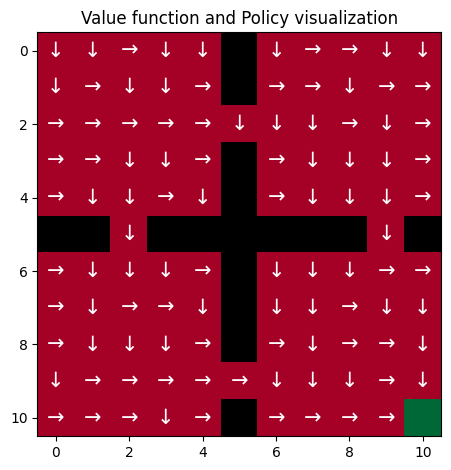

In [181]:
# Defining the environment
np.random.seed(54)
env = FourRoomsEnv()
# Defining the policy
pi = {s:np.random.choice([1,2]) for s in env.states()}
# Visualizing the environment and policy
zero_values = np.zeros(env.shapes[0])
zero_values[env.terminal] = 1
env.plot_values_policy(zero_values, pi, plot_all_policy = True, cbar=False)
np.random.seed(None)

### 1.2. DP Policy Evaluation
Last time, you had to implement the DP solution for it. No need to redo it this time, here's the value function $v_\pi$ of our policy $\pi$ for all the states:

In [182]:
class DP_PolicyEvaluation():
    def __init__(self, mdp):
        self.mdp = mdp
        self.gamma = self.mdp.gamma
        self.V = np.zeros(self.mdp.shapes[0])
        
    def run(self, pi, delta):
        sweeps = 0
        while True:
            norm = 0
            sweeps += 1
            for s in self.mdp.states():
                if not self.mdp.is_terminal(s):
                    v = self.V[s]
                    a = pi[s]
                    psa = self.mdp.p(s,a)
                    self.V[s] = sum([psa[s_,r]*(r+self.gamma*self.V[s_]) for s_,r in psa.keys()])
                    norm = max(norm, abs(v-self.V[s]))
            # exit condition
            if norm < delta:
                print("Exiting PEval through norm={:7f} < {:7f}=delta after {} sweeps".format(norm, delta, sweeps))
                break
        

Exiting PEval through norm=0.000000 < 0.001000=delta after 15 sweeps


C:\Users\Maksim Karnaukh\AppData\Local\Temp\ipykernel_16972\3500582730.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


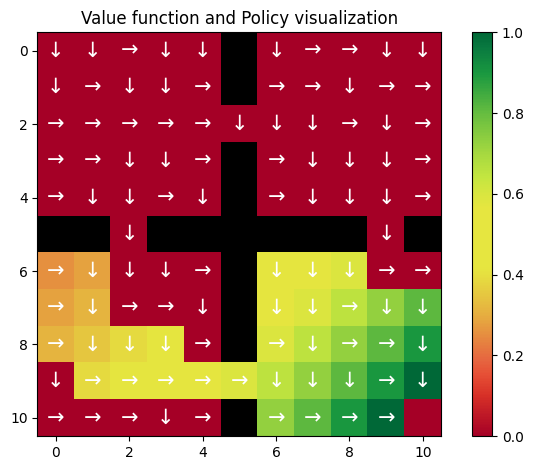

In [183]:
agent_dp = DP_PolicyEvaluation(env)
agent_dp.run(pi, delta=1e-3)
env.plot_values_policy(agent_dp.V, pi, plot_all_policy = True)

### 1.3.  <span style="color:blue"> **TODO** </span> TD Policy Evaluation

We will now find $v_\pi$ simply by interacting with the environment, using Temporal Difference Learning.

- <span style="color:red"> **TODO** </span>: **Remind** the main difference between Monte Carlo methods and Temporal Difference Learning. <br/> 
Monte Carlo methods wait until the end of a (complete) episode to update the value function (increment to $V(S_{t})$), while TD Learning updates the value function at each time step (need to wait only until the next time step), based on the observed reward ($R_{t+1}$) and the estimate of the next state's value ($V(S_{t+1})$).

- <span style="color:blue"> **TODO** </span>: **Implement** TD Policy Evaluation provided the policy $\pi$ we have already evaluated.

In [184]:
class TDPolicyEval():
    """ Given a policy, uses that policy to act in the environment.
    Learns its V value.
    """
    def __init__(self, env_shapes, pi, epsilon=0.1, gamma=0.9, alpha=0.1, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.gamma = gamma
        self.epsilon = epsilon
        self.pi = pi
        self.alpha = alpha
        
        self.V = np.zeros(self.input_shape)
        
        self.reset()

    def reset(self):
        # DONE
        self.V = np.zeros(self.input_shape)
        
    def act(self, s):
        # DONE
        return self.pi[s]

    def learn(self, s, a, r, s_, d=False):
        # DONE
        if not d:
            self.V[s] += self.alpha*(r + self.gamma*self.V[s_] - self.V[s])
        else:
            self.V[s] += self.alpha*(r - self.V[s])

In [185]:
# Learning and visualization. Nothing to do here.
def learn_v_pi(agent, env, n_episodes):
    evaluations_history = []
    agent.reset()
    first = True
    # Training phase
    for ep in range(n_episodes):
        s = env.reset()
        while True: # step limit implemented in Env
            action = agent.act(s) # must be = pi[s]
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            if done:
                break
            s = s_
        if first and np.any(agent.V != 0):
            print("V visualization after the first rewarding episode observed - episode {}:".format(ep))
            env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
            first = False
        if not first and not ep % 200:
            print("V visualization after episode {}:".format(ep))
            env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
        
    print("Final V visualization: ")
    env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
    env.close()

We're using Exploring Starts as before, because we want to see the Value map for all states.

V visualization after the first rewarding episode observed - episode 0:


C:\Users\Maksim Karnaukh\AppData\Local\Temp\ipykernel_16972\3500582730.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


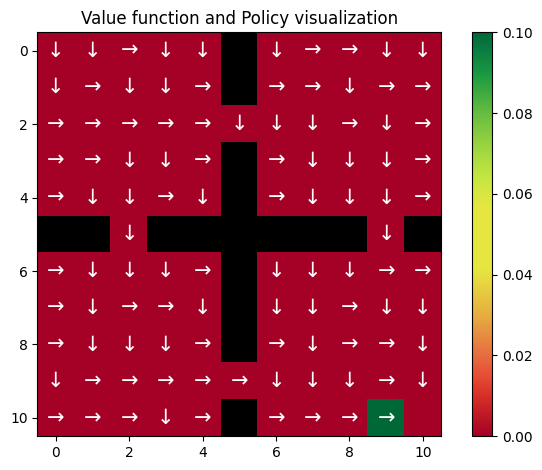

V visualization after episode 0:


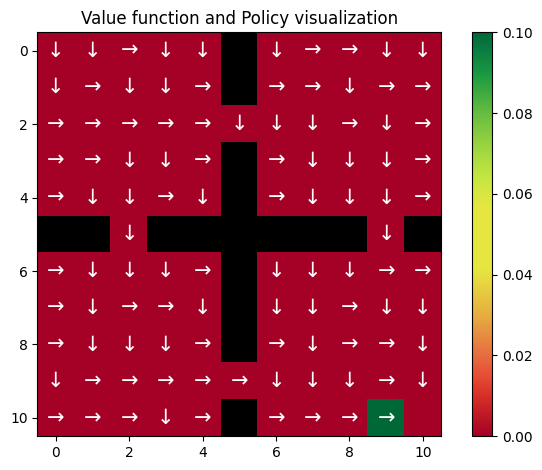

V visualization after episode 200:


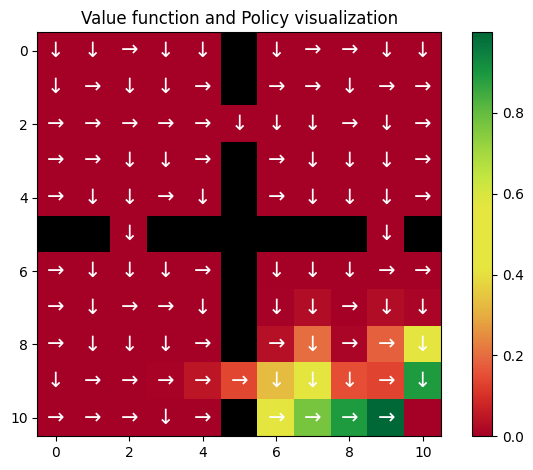

V visualization after episode 400:


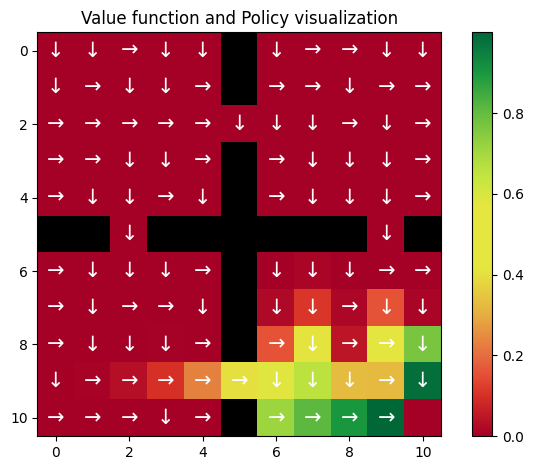

V visualization after episode 600:


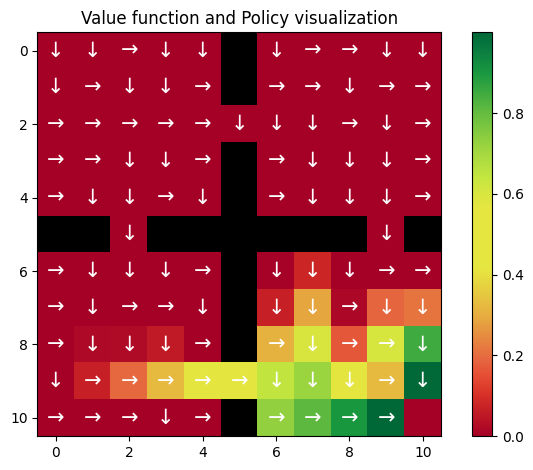

V visualization after episode 800:


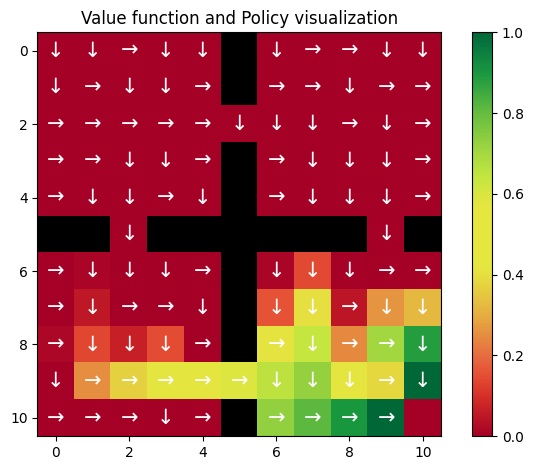

Final V visualization: 


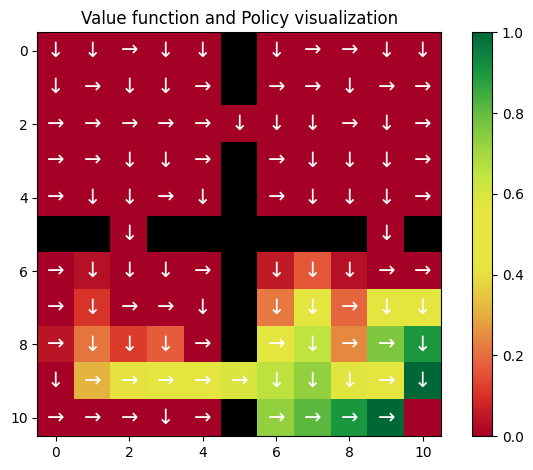

In [186]:
env = FourRoomsEnv(explo_starts=True, max_steps = 50)
d = {
    'env_shapes': env.shapes,
    'epsilon': 0.2,
    'alpha' : 0.1,
    'gamma': env.gamma,
    'pi' : pi
}
agent_td = TDPolicyEval(**d)
learn_v_pi(agent_td, env, 1000)

Reminder, to compare with the DP solution:

C:\Users\Maksim Karnaukh\AppData\Local\Temp\ipykernel_16972\3500582730.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


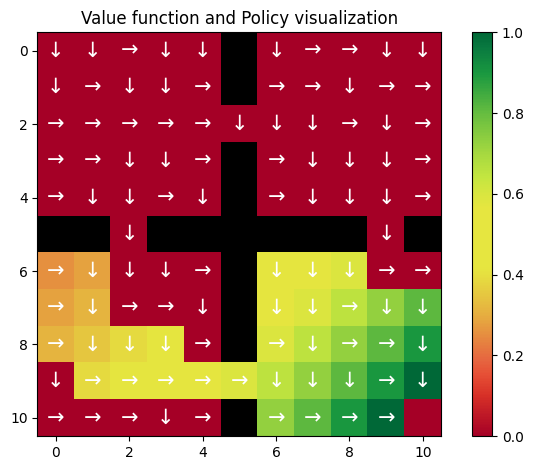

In [187]:
env.plot_values_policy(agent_dp.V, pi, plot_all_policy = True)

<span style="color:red"> **TODO** </span>: As you might notice, TD isn't as fast as was MC in this case. This is due to the very specific problem we're trying to solve, **can you see why**? **What** could we do to take advantage of the situation? If you have an idea, **apply** your changes and show the difference in a cell below.


Answer: 
"This is due to the very specific problem we're trying to solve", I don't really understand what is meant by this, but one of the reasons for this might be that since we have reward 0 everywhere except the goal state, it might be more difficult to propagate backwards if we use only TD(0) and it will take longer to converge. If I run it again (multiple times) using a higher step size (alpha), it gives better results.

V visualization after the first rewarding episode observed - episode 2:


C:\Users\Maksim Karnaukh\AppData\Local\Temp\ipykernel_16972\3500582730.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


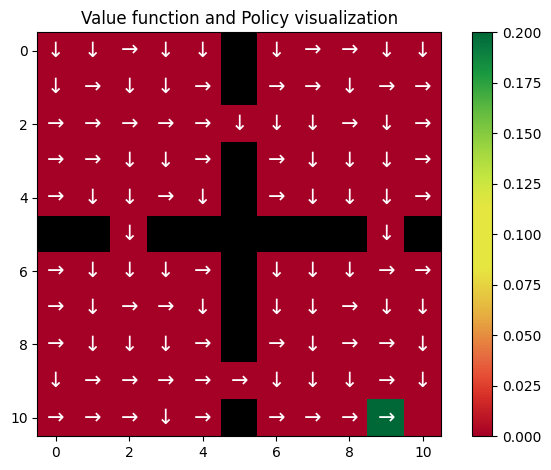

V visualization after episode 200:


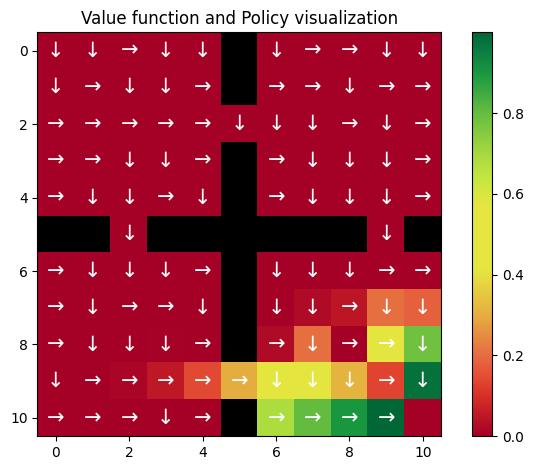

V visualization after episode 400:


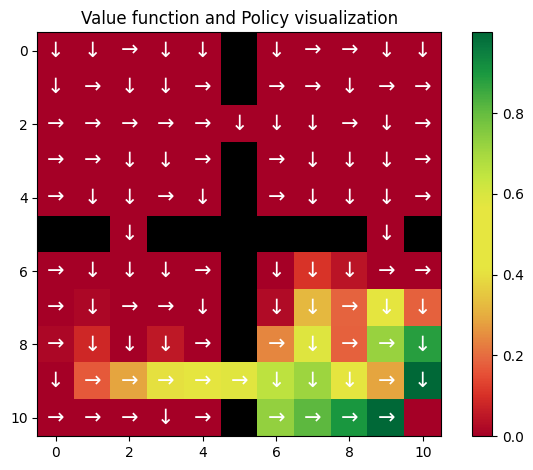

V visualization after episode 600:


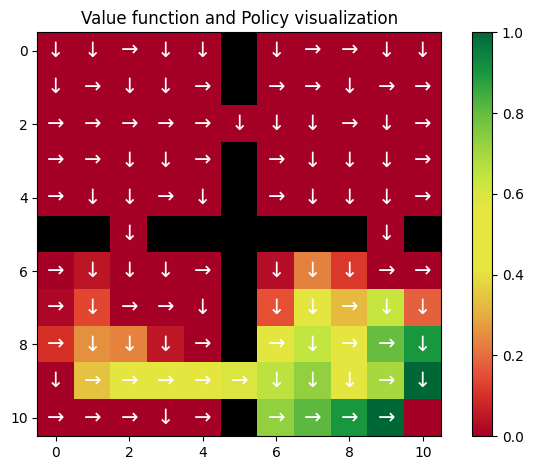

V visualization after episode 800:


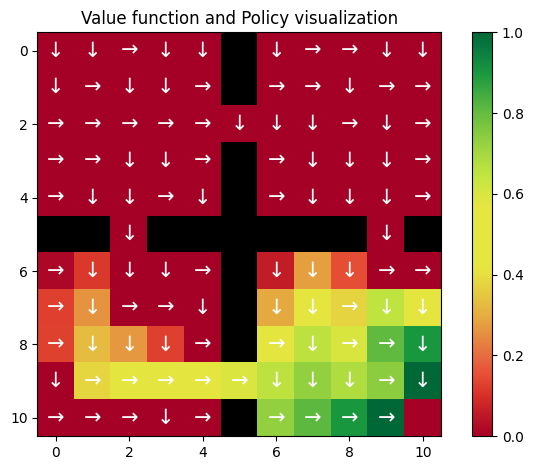

Final V visualization: 


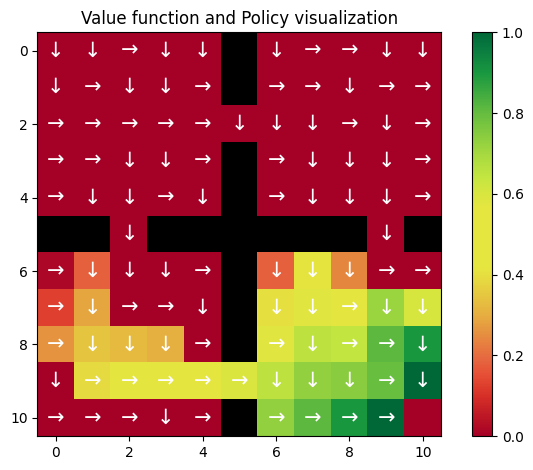

In [188]:
env = FourRoomsEnv(explo_starts=True, max_steps = 50)
d = {
    'env_shapes': env.shapes,
    'epsilon': 0.2,
    'alpha' : 0.2,
    'gamma': env.gamma,
    'pi' : pi
}
agent_td = TDPolicyEval(**d)
learn_v_pi(agent_td, env, 1000)

## 2. <span style="color:green"> (2 points) </span> <span style="color:blue"> **TODO** </span> SARSA
SARSA is the Control version of TD-learning. 

- <span style="color:red"> **TODO** </span> **Remind** how to get from TD to SARSA, and the theoretical justification behind this.<br/> 
Now we consider transitions from state–action pair to state–action pair, and learn the values of state–action pairs. 
The theorems assuring the convergence of state values under TD(0) also apply to the corresponding algorithm for action values:
$Q(S_{t}, A_{t}) \leftarrow Q(S_{t}, A_{t}) + \alpha[R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)]$ <br/>
This update is done after every transition from a nonterminal state $S_{t}$. If $S_{t+1}$ is terminal, then $Q(S_{t+1}, A_{t+1})$ is defined as zero.
- <span style="color:blue"> **TODO** </span> **Implement** SARSA.

In [189]:
# Nothing to do in this cell.
def allmax(a):
    """ Returns all occurences of the max """
    if len(a) == 0:
        return []
    all_ = [0]
    max_ = a[0]
    for i in range(1, len(a)):
        if a[i] > max_:
            all_ = [i]
            max_ = a[i]
        elif a[i] == max_:
            all_.append(i)
    return all_

def my_argmax(v):
    """ Breaks ties randomly. """
    return random.choice(allmax(v))

In [190]:
class SARSA():
    """ Tabular method that keeps the Q-values of all the possible
    state-action pairs; applies TD for Policy Evaluation. 
    On-Policy algo using epsilon-greedy.
    """
    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, alpha=.1, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        # if you have stuff to add
        self.Q = np.zeros((*self.input_shape, self.n_actions))

    def reset(self):
        # DONE
        self.Q = np.zeros((*self.input_shape, self.n_actions))

    def act(self, s):
        # DONE
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            return my_argmax(self.Q[s])

    def learn(self, s, a, r, s_, d=False):
        # DONE
        if not d:
            a_ = self.act(s_)
            self.Q[s][a] += self.alpha*(r + self.gamma*self.Q[s_][a_] - self.Q[s][a])
        else:
            self.Q[s][a] += self.alpha*(r - self.Q[s][a])
            

In [191]:
def view_train_agent(agent, env, n_episodes, plot=True, out_reward=False):
    """ Trains an agent on an env for a given amount of steps.
    If out_reward=False, returns the steps_history of the agent, i.e. number of steps each episode took.
    If out_reward=True, returns the running reward."""
    view = [0,1,3,5,10,100,500]
    agent.reset()
    # Training phase
    returns_history = np.empty(n_episodes) # all cumulative rewards during training
    steps_history = np.empty(n_episodes)
    for ep in range(n_episodes):
        t = 0
        s = env.reset()
        cum_r = 0 # cumulative reward
        while True:
            action = agent.act(s)
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            cum_r += reward
            if done:
                break
            s = s_
            t += 1
        if plot and ep in view:
            print("Best Q and action after episode {}:".format(ep))
            best_qs = np.max(agent.Q, axis=-1)
            greedy_policy = np.argmax(agent.Q, axis=-1)
            env.plot_values_policy(best_qs, greedy_policy)

        steps_history[ep] = t
        returns_history[ep] = cum_r
        
    if plot:
        print("Final Q and policy:")
        best_qs = np.max(agent.Q, axis=-1)
        greedy_policy = np.argmax(agent.Q, axis=-1)
        env.plot_values_policy(best_qs, greedy_policy)
    env.close()
    if out_reward:
        return returns_history
    else:
        return steps_history

Since there is now stochastic exploration, the episodes will all reach the terminal state, if given enough time. We can remove both the step limit and Exploring Starts.

Best Q and action after episode 0:


C:\Users\Maksim Karnaukh\AppData\Local\Temp\ipykernel_16972\3500582730.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


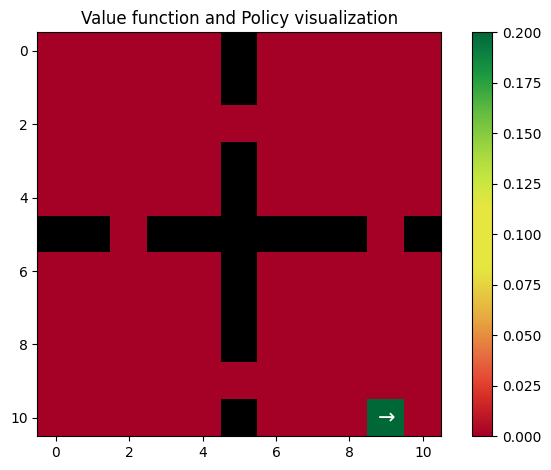

Best Q and action after episode 1:


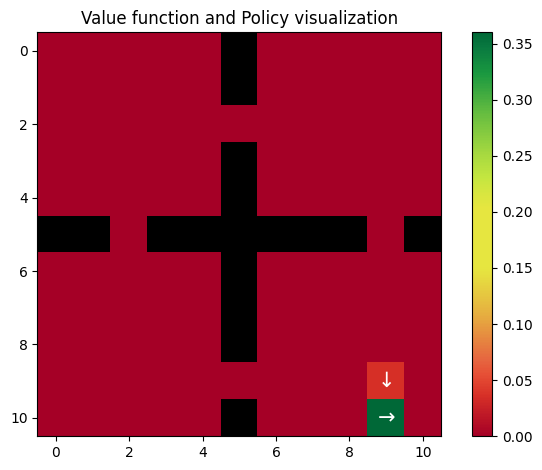

Best Q and action after episode 3:


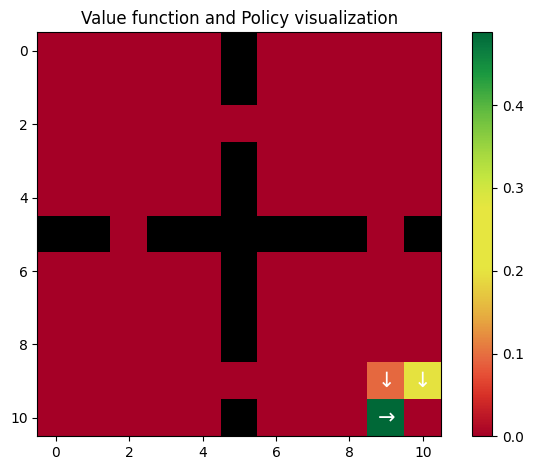

Best Q and action after episode 5:


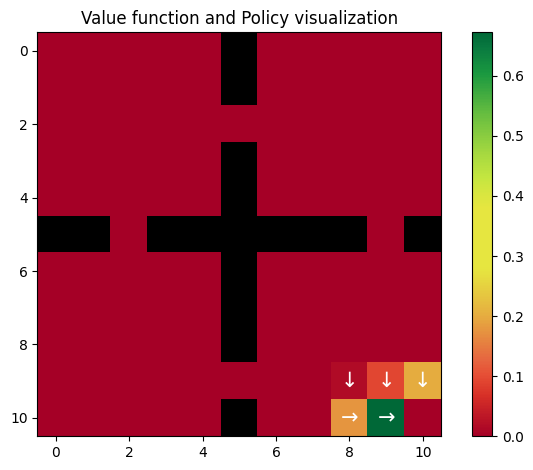

Best Q and action after episode 10:


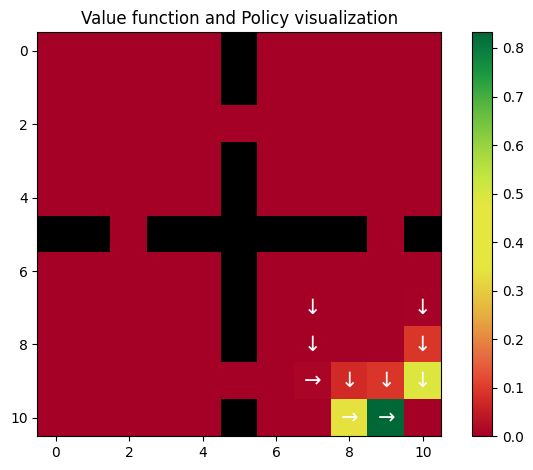

Best Q and action after episode 100:


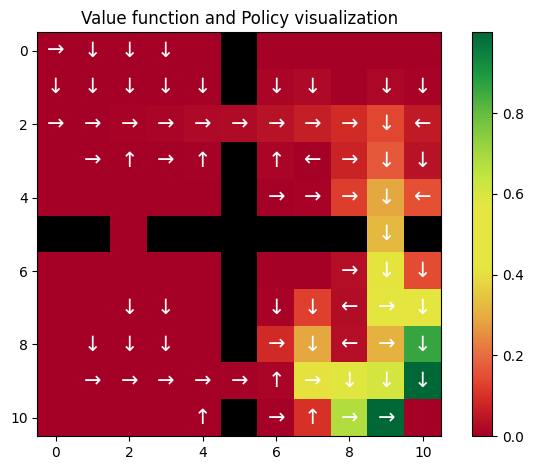

Best Q and action after episode 500:


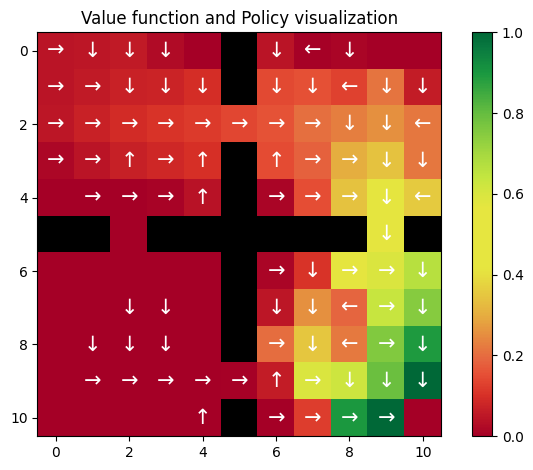

Final Q and policy:


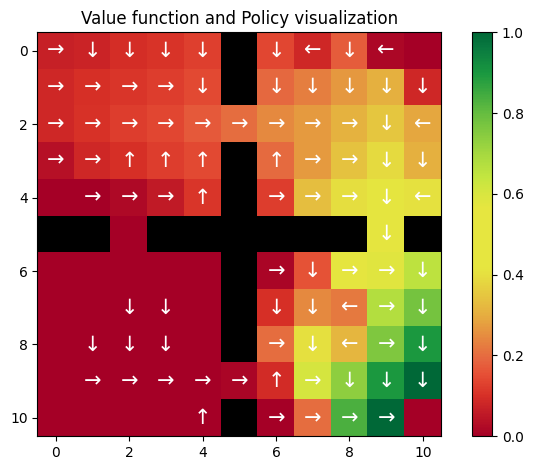

In [192]:
env = FourRoomsEnv()
d = {
    'env_shapes': env.shapes,
    'alpha' : 0.2,
    'epsilon': 0.2,
    'gamma': env.gamma,
    'q0' : 0,
}
agent = SARSA(**d)
perf_sarsa = view_train_agent(agent, env, 2000)

As a reminder, below are the values found by two independ runs of an epsilon-greedy Monte Carlo algorithm.

<table><tr>
<td> 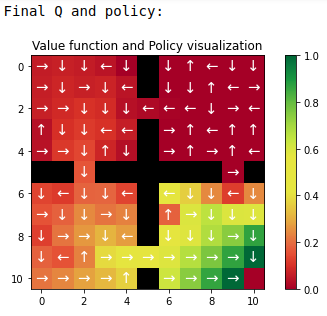 </td>
<td> 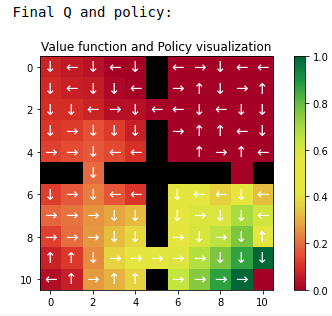 </td>
</tr></table>

<span style="color:red"> **TODO** </span>: **Can** you see a difference in the found policies? **Explain** why this is happening.
We can indeed see some difference in the found policies. It seems like SARSA has a lot more states with no new value (I think it's zero in this case, and no real updated policy there contrary to the 25% stochastic one) than the Monte Carlo algorithm. In the case that I am writing this, this is visible in the lower left room for SARSA. The reason for this might be that SARSA, to update the Q-value for a state-action pair, look at the next state and the epsilon-greedy action from that state if we look at the formula. If the surrounding was not updated (because it's possibly 'bad'), it might not update the current state-action pair either (the reward is 0). This is not the case for Monte Carlo, which updates the value of a state-action pair based on the return from that state on (of the whole episode, so until terminal state). 

## 3. <span style="color:green"> (2 points) </span> <span style="color:blue"> **TODO** </span> QLearning

### 3.1. <span style="color:blue"> **TODO** </span> Vanilla QLearning

- <span style="color:red"> **TODO** </span> **Explain** the difference in approach between SARSA and QLearning. <br/> 
First of all, Q-learning is an **off-policy** TD control algorithm. The formula is: $Q(S_{t}, A_{t}) \leftarrow Q(S_{t}, A_{t}) + \alpha[R_{t+1} + \gamma \max_{a} Q(S_{t+1}, a) - Q(S_t, A_t)]$.
Here, we still use the policy to determine which state-action pairs to update and visit, but contrary to SARSA, **the update is done based on the maximum Q-value (over all actions) of the next state**, so independent of the current policy being followed.
- <span style="color:blue"> **TODO** </span> **Implement** QLearning.

In [193]:
class QLearning():
    
    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, alpha=0.1, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        # if you have stuff to add
        self.Q = np.zeros((*self.input_shape, self.n_actions))

    def reset(self):
        # DONE
        self.Q = np.zeros((*self.input_shape, self.n_actions))

    def act(self, s):
        # DONE
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            return my_argmax(self.Q[s])

    def learn(self, s, a, r, s_, d=False):
        # DONE
        if not d:
            self.Q[s][a] += self.alpha*(r + self.gamma*max(self.Q[s_]) - self.Q[s][a])
        else:
            self.Q[s][a] += self.alpha*(r - self.Q[s][a])

Best Q and action after episode 0:


C:\Users\Maksim Karnaukh\AppData\Local\Temp\ipykernel_16972\3500582730.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


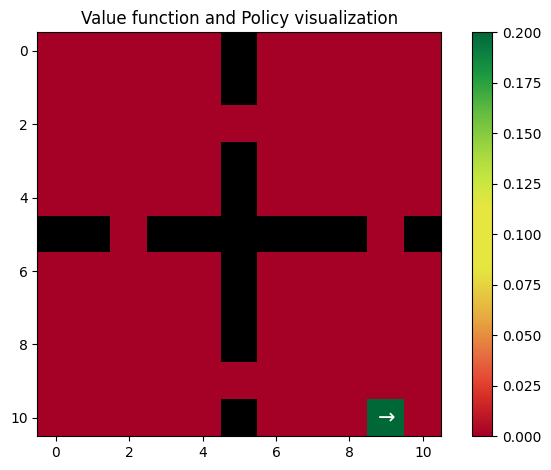

Best Q and action after episode 1:


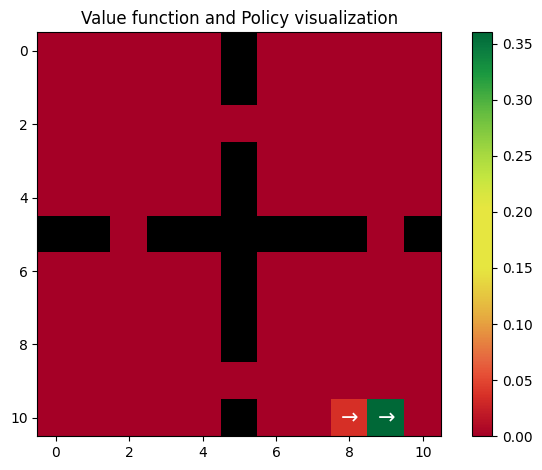

Best Q and action after episode 3:


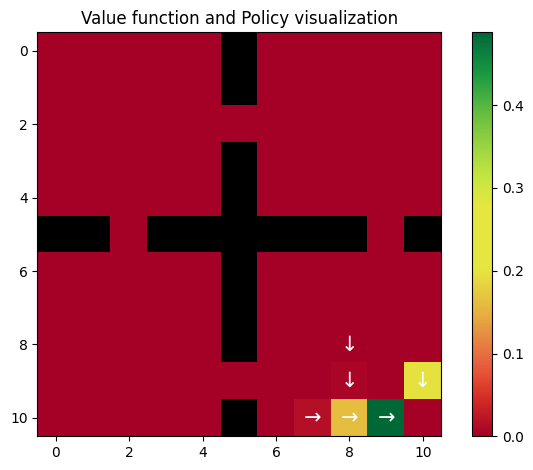

Best Q and action after episode 5:


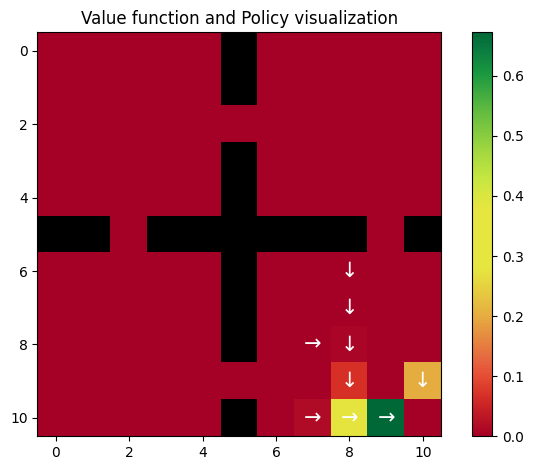

Best Q and action after episode 10:


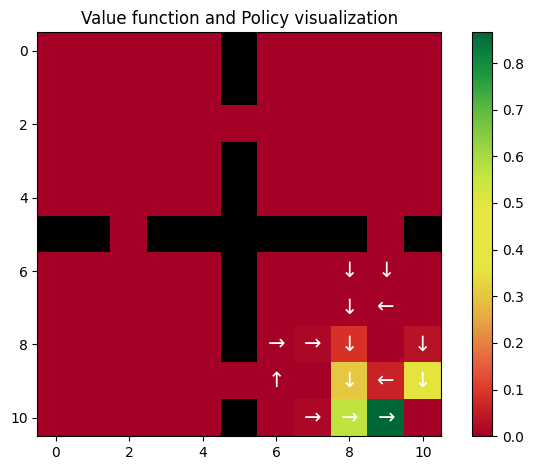

Best Q and action after episode 100:


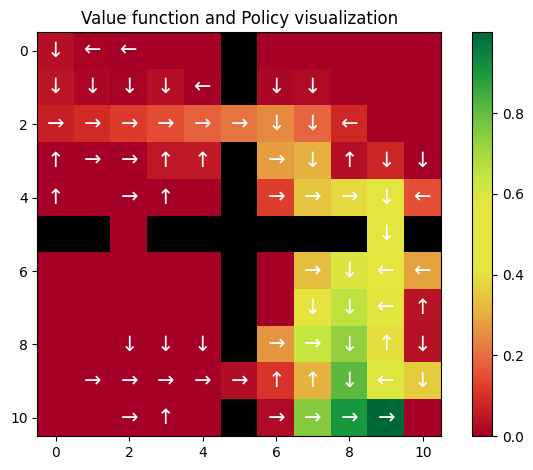

Best Q and action after episode 500:


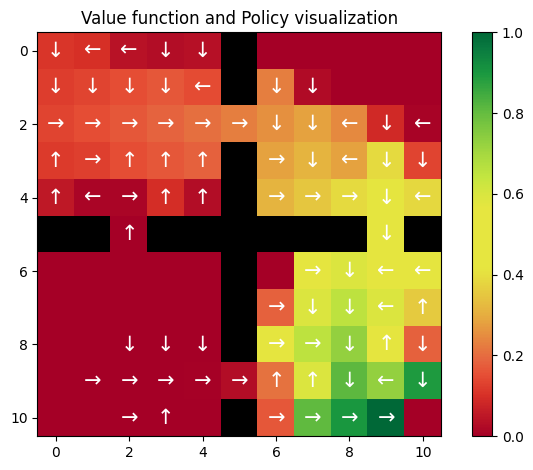

Final Q and policy:


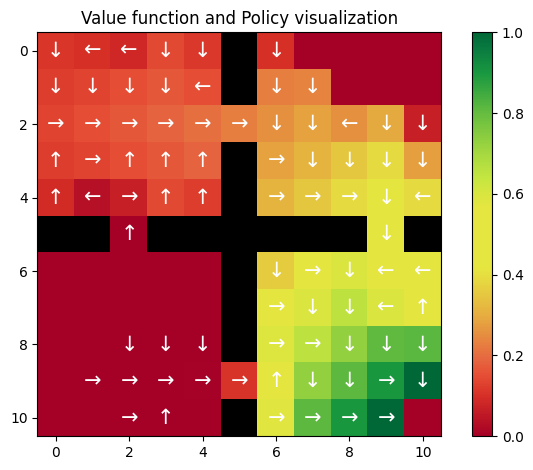

In [194]:
env = FourRoomsEnv()
shapes = (tuple([env.observation_space[i].n for i in range(len(env.observation_space))]), env.action_space.n)
d = {
    'env_shapes': shapes,
    'epsilon': 0.2,
    'alpha' : 0.2,
    'gamma': env.gamma,
}
agent = QLearning(**d)
perf_ql = view_train_agent(agent, env, 2000)

<span style="color:red"> **TODO** </span>: **Interpret** briefly your results.
Here, we can see that there are quite a lot of states with no new value (I think it's zero in this case, and no real updated policy there) for Q Learning as well. This is visible in the top right room for the run that I am describing (almost everything there is red with no arrows). The reason is pretty much the same I think, because now we just take the max over actions of the next state Q-value.

### 3.2. <span style="color:blue"> **TODO** </span> Double Q Learning
The benefits of Double Q Learning are clearest when using a very simple environment with the following MDP:
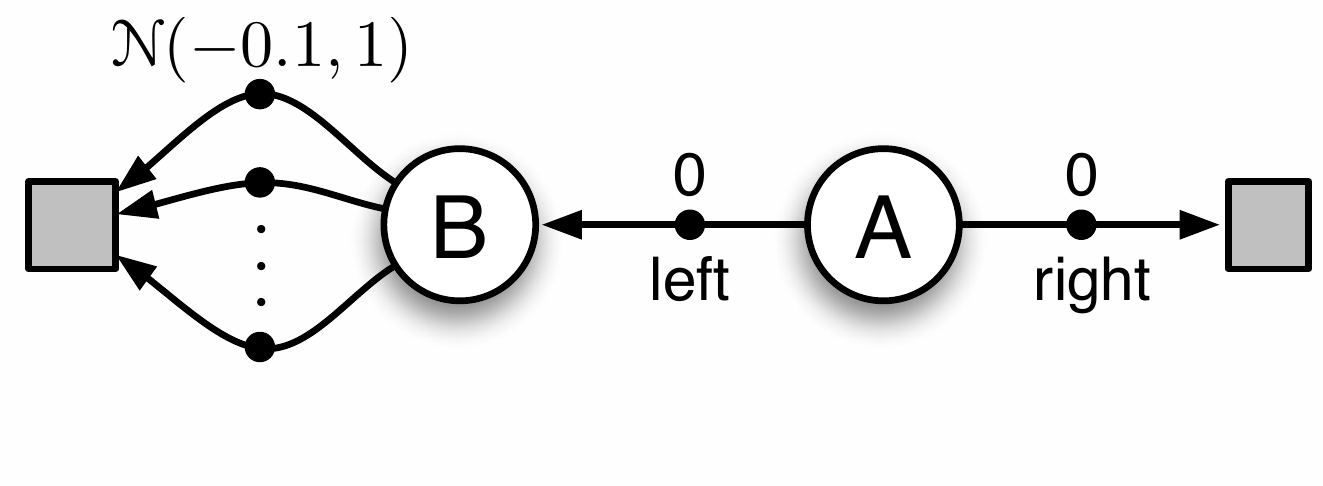

In [195]:
class MaxBiasEnv(gym.Env):
    def __init__(self):
        # We choose arbitrarily the number of actions from B out
        self.n_actions = 10
        self.action_space = spaces.Discrete(self.n_actions)
        self.shapes = ((3,),self.n_actions)
        self.observation_space = spaces.Discrete(3) # A:0, B:1, Terminal: 2
        self.gamma = 0.9
        # begin in start state
        self.reset()

    def reset(self):
        self.s = 1 # A
        return self.s

    def step(self, action):
        """ Moves the agent in the action direction."""
        r = 0
        if self.s == 1: # State A
            # this is kind of lazy programming so that you can use your QLearning agent, but it means there are
            # much more actions from A than necessary.
            self.s += 2*(action%2) - 1 # {left, right}={0,1} -> {-1, 1}
        elif self.s == 0: # State B
            self.s = 2  # any action is terminal
            r = np.random.randn() - 0.1
        # Returns
        done = (self.s==2)
        return self.s, r, done, {}

We will need to run these experiments many times to observe the expected result.

In [196]:
def train_agent_maxbias(agent, env, n_episodes):
    """ Focuses on the amount of correct (right) action from A"""
    agent.reset()
    # Training phase
    right_history = np.empty(n_episodes)
    for ep in range(n_episodes):
        s = env.reset()
        while True:
            action = agent.act(s)
            if s==1: # A
                right_history[ep] = action%2
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            if done:
                break
            s = s_        
    env.close()
    return right_history
    
def multiple_train_agent_maxbias(agent, env, n_episodes, n_s, out_reward=False):
    perfs = np.empty((n_s, n_episodes))
    for i in range(n_s):
        perfs[i] = train_agent_maxbias(agent, env, n_episodes)
    return np.mean(perfs, 0)

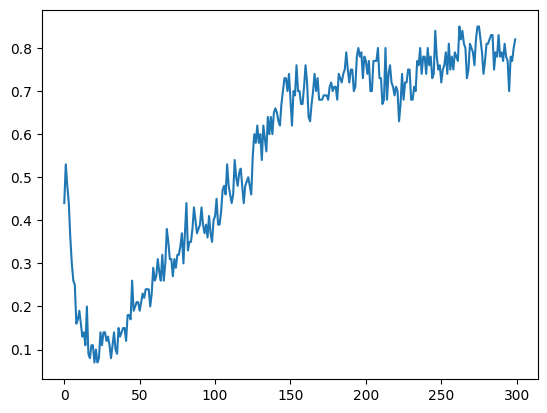

In [197]:
env = MaxBiasEnv()
d["env_shapes"] = env.shapes
agent = QLearning(**d)
perf_ql = multiple_train_agent_maxbias(agent, env, 300, 100)
plt.plot(perf_ql)

- <span style="color:red"> **TODO** </span> **Explain** the problem that QLearning has that DoubleQLearning attempts to solve, as well as the attempted solution.
QLearning has the problem of the maximization bias, meaning that the Q-values are 'overestimated' (we use the maximum of the estimates as an estimate of the maximum of the true values). DoubleQLearning tries to solve this by using two Q-values (Q1 and Q2), and using one to select the maximizing action and the other to provide the estimate of its value. This way, we avoid the maximization bias.

- <span style="color:blue"> **TODO** </span> **Implement** Double Q Learning.

In [198]:
class DoubleQLearning():
        
        def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, alpha=0.1, **kwargs):
            if env_shapes is not None: # otherwise, bandits
                self.input_shape, self.n_actions = env_shapes
            self.gamma = gamma
            self.epsilon = epsilon
            self.alpha = alpha
            # if you have stuff to add
            self.Q1 = np.zeros((*self.input_shape, self.n_actions))
            self.Q2 = np.zeros((*self.input_shape, self.n_actions))
    
        def reset(self):
            # DONE
            self.Q1 = np.zeros((*self.input_shape, self.n_actions))
            self.Q2 = np.zeros((*self.input_shape, self.n_actions))
    
        def act(self, s):
            # DONE
            if np.random.rand() < self.epsilon:
                return np.random.choice(self.n_actions)
            else:
                return my_argmax(self.Q1[s] + self.Q2[s])
    
        def learn(self, s, a, r, s_, d=False):
            # DONE
            if not d:
                if np.random.rand() < 0.5:
                    self.Q1[s][a] += self.alpha*(r + self.gamma*self.Q2[s_][my_argmax(self.Q1[s_])] - self.Q1[s][a])
                else:
                    self.Q2[s][a] += self.alpha*(r + self.gamma*self.Q1[s_][my_argmax(self.Q2[s_])] - self.Q2[s][a])
            else:
                if np.random.rand() < 0.5:
                    self.Q1[s][a] += self.alpha*(r - self.Q1[s][a])
                else:
                    self.Q2[s][a] += self.alpha*(r - self.Q2[s][a])

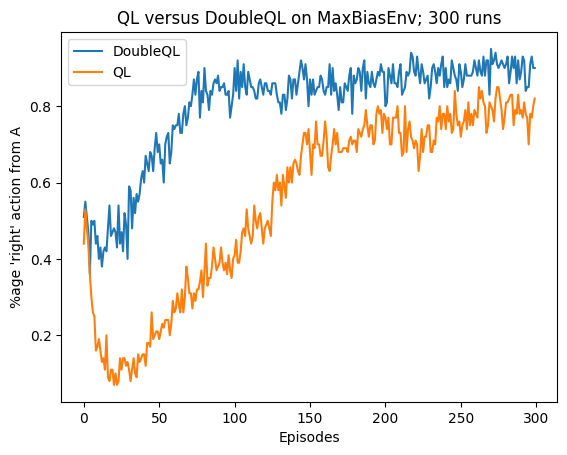

In [199]:
env = MaxBiasEnv()
d["env_shapes"] = env.shapes
agent = DoubleQLearning(**d)
perf_dql = multiple_train_agent_maxbias(agent, env, 300, 100)

# Comaprison plot:
plt.plot(perf_dql, label="DoubleQL")
plt.plot(perf_ql, label="QL")
plt.legend(); plt.title("QL versus DoubleQL on MaxBiasEnv; 300 runs")
plt.xlabel("Episodes"); plt.ylabel("%age 'right' action from A") 
plt.show()

<span style="color:red"> **TODO** </span> **Interpret** your results.

We can see that DoubleQLearning in general performs quite better than QLearning in terms of selecting the 'right' action. This is because of the maximization bias that QLearning has, which DoubleQLearning almost eliminates as we can see on the graph (it also converges to the optimal line faster). 

## 4. <span style="color:green"> (2 point) </span> <span style="color:red"> **TODO** </span> Windy Environment Comparison 
The 4 Room Environment use until now is convenient to track and understand how values are updated, but the deterministic setting makes it hard to compare the algorithms in general.

Let's add noise to the environment. To prevent the noise from helping exploration (if it was just some randomness in the actions), we add wind: the agent is sometimes pushed to the right in the upper part of the environment, and to the left in the lower part, as if there were two opposite gusts of wind or big fans.

In this section there will be nothing to implement! Just run the cells and interpret the final results.

In [200]:
class FourRoomsWindyEnv(FourRoomsEnv):    
    def step(self, action):
        """ Moves the agent in the action direction."""
        # Next, moving according to action
        x, y = self.moves[action]                
        # CHANGE: Apply wind. Agent might clip through walls by luck, but it's fine
        if self.s[0] < self.height//2:
            if np.random.rand() < 0.15:
                y += 1
        else:
            if np.random.rand() < 0.15:
                y -= 1
        if (self.s[0]+x, self.s[1]+y) not in self.obstacles:
            # move is allowed

            self.s = self.s[0] + x, self.s[1] + y
        

        # Finally, setting the agent back into the grid if fallen out
        self.s = (max(0, self.s[0]), max(0, self.s[1]))
        self.s = (min(self.s[0], self.height - 1),
                  min(self.s[1], self.width - 1))

        self.t += 1
        done_goal = (self.s == self.terminal)
        done = done_goal
        if self.max_steps is not None and self.t == self.max_steps:
            done = True
            self.t = 0
        return self.s, int(done_goal), done, {}

Now we would like to test all our agents so far on this environment. First, let's reintroduce the On-policy MC agent:

In [201]:
class EGMonteCarlo():
    """ Tabular method that keeps the Q-values of all the possible
    state-action pairs; updates on an episode-wise schedule
    On-Policy version using epsilon-greedy
    """
    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.gamma = gamma
        self.epsilon = epsilon
        self.reset()

    def _episodic_reset(self):
        """ Resets the history, G and W variables for another episode """
        self.trajectory = []

    def reset(self):
        self.Q = np.zeros((*self.input_shape, self.n_actions)) # Q value estimates
        self.C = np.zeros((*self.input_shape, self.n_actions))
        self._episodic_reset()

    def act(self, s):
        """ Epsilon-greedy policy over the Qtable """
        s = tuple(s) # to access somewhere in the table
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.n_actions)
        else:
            action = my_argmax(self.Q[s])

        return action

    def learn(self, s, a, r, s_, d=False):
        """ Only applies the update over the whole episode when the latter has
        terminated and a history is available. Stocks said history. """
        assert type(d) is bool, "MonteCarlo needs a boolean done signal."
        self.trajectory.append([s,a,r])
        if d:
            G = 0
            for s,a,r in reversed(self.trajectory):
                G = G*self.gamma + r
                self.C[s][a] += 1
                self.Q[s][a] += (G - self.Q[s][a])/self.C[s][a]

            self._episodic_reset()

In [202]:
env = FourRoomsWindyEnv()

Before anything, run the next cell to visualize QLearning's solution of our modified environment:

Best Q and action after episode 0:


C:\Users\Maksim Karnaukh\AppData\Local\Temp\ipykernel_16972\3500582730.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


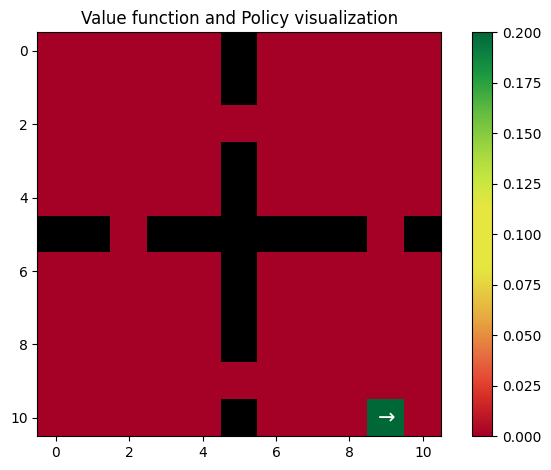

Best Q and action after episode 1:


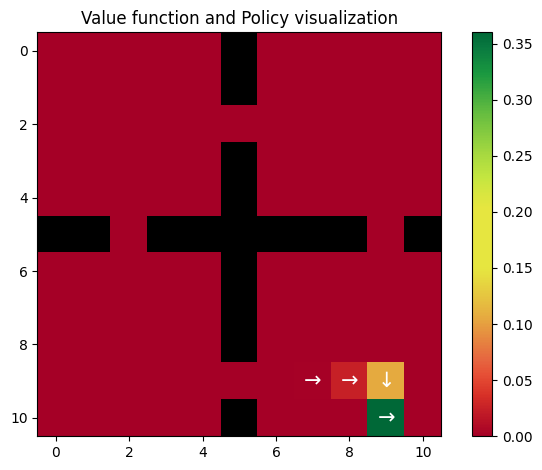

Best Q and action after episode 3:


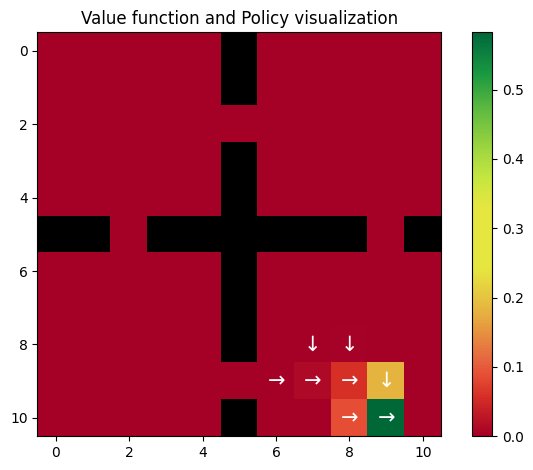

Best Q and action after episode 5:


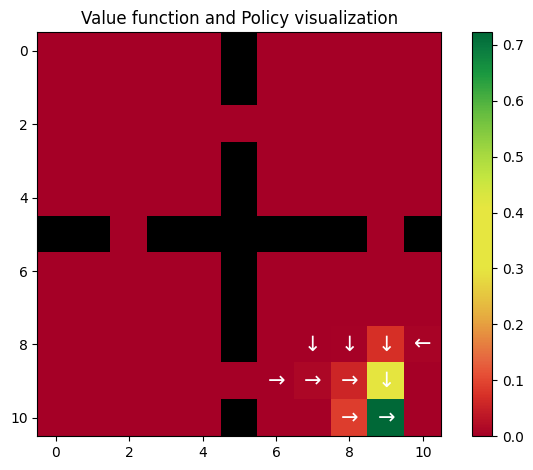

Best Q and action after episode 10:


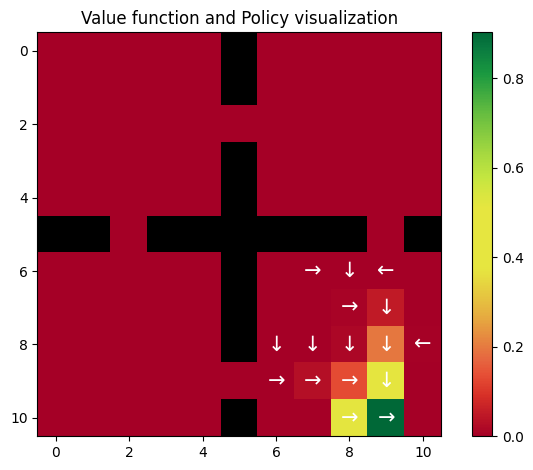

Best Q and action after episode 100:


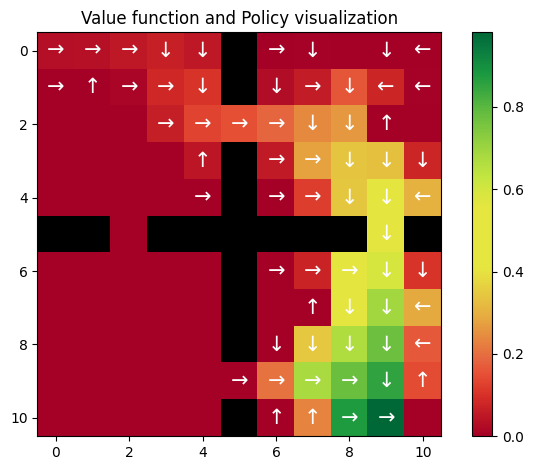

Best Q and action after episode 500:


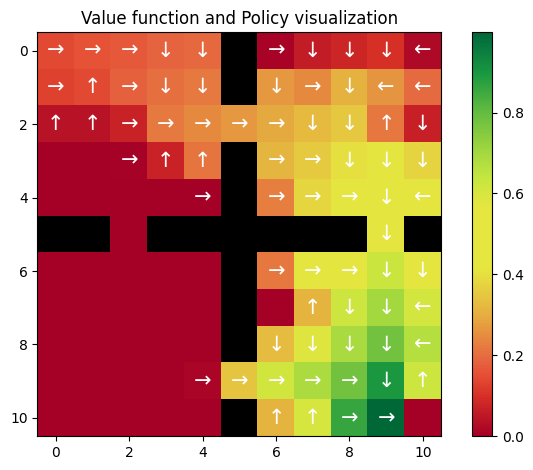

Final Q and policy:


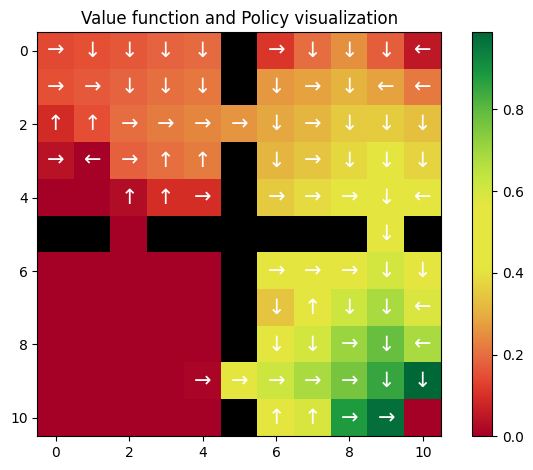

In [203]:
d = {
    'env_shapes': env.shapes,
    'epsilon': 0.2,
    'alpha' : 0.2,
    'gamma': env.gamma,
}
agent = QLearning(**d)
perf_ql = view_train_agent(agent, env, 2000)

Let's compare the number of steps needed to reach the goal during learning. 

Since a lot of randomness is now involved in the process, and different random seeds might lead to vastly different performances, we will now average over $n_s=100$ random seeds to obtain an estimate of the average performance.

If your python setup and PC support the `parallel_` function, feel free to use it to speed the computation up by a factor of around 2. It was quite lazy programming, so be careful not to have too much stuff open or it might crash; sorry about that. Otherwise, use the `multiple_train_agent` function below to run each agent over multiple seeds.

In [204]:
import time
def multiple_train_agent(agent, env, n_episodes, n_s, out_reward=False):
    init = time.time()
    perfs = np.empty((n_s, n_episodes))
    for i in range(n_s):
        perfs[i] = view_train_agent(agent, env, n_episodes, plot=False)
    end = time.time()
    print("Done in {}s".format(end-init))
    return np.mean(perfs, 0)

from multiprocessing import Pool
def single_process(agent, env, n_episodes, n_s, n_p):
    out = []
    for i in range(n_s//n_p):
        out.append(view_train_agent(agent, env, n_episodes, plot=False))
    return out

def parallel_multiple_train_agent(agent, env, n_episodes, n_s, out_reward=False):
    init = time.time()
    n_p = 5
    with Pool(n_p) as p:
        outs = p.starmap(single_process, [[agent, env, n_episodes, n_s, n_p]]*n_p)
    outs = np.concatenate(outs, 0)
    end = time.time()
    print("Done in {}s".format(end-init))
    return np.mean(outs, 0)

In [205]:
def make_plot(l, suptitle, title, xlabel, ylabel,
              labels=None, interval_yaxis=None, colors=None, alphas=None):
    """ Simply saves a plot with multiple usual arguments."""
    n = len(labels)
    if colors is None:
        colors = [None]*n
    if alphas is None:
        alphas = [None]*n
    for perf, label, color, alpha in zip(l, labels, colors, alphas):
        plt.plot(perf, label=label, color=color, alpha=alpha)
    plt.legend()

    plt.suptitle(suptitle, fontsize=14, fontweight='bold')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if interval_yaxis is not None:
        new_y1, new_y2 = interval_yaxis
        x1,x2,y1,y2 = plt.axis()
        plt.axis((x1,x2,new_y1,new_y2))

    plt.plot()

Now testing all agents! The runs should take less than a minute.

In [206]:
n_episodes = 1000
n_s = 100
d['epsilon'] = 0.1

In [207]:
# Monte Carlo:
agent = EGMonteCarlo(**d)
# perf_mc = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
perf_mc = multiple_train_agent(agent, env, n_episodes, n_s)

Done in 35.570812940597534s


In [208]:
# SARSA:
agent = SARSA(**d)
# perf_sarsa = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
perf_sarsa = multiple_train_agent(agent, env, n_episodes, n_s)

Done in 46.485164403915405s


In [209]:
# QLearning:
agent = QLearning(**d)
# perf_ql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
perf_ql = multiple_train_agent(agent, env, n_episodes, n_s)

Done in 38.19329476356506s


In [210]:
# DoubleQLearning:
agent = DoubleQLearning(**d)
# perf_dql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
perf_dql = multiple_train_agent(agent, env, n_episodes, n_s)

Done in 59.25087642669678s


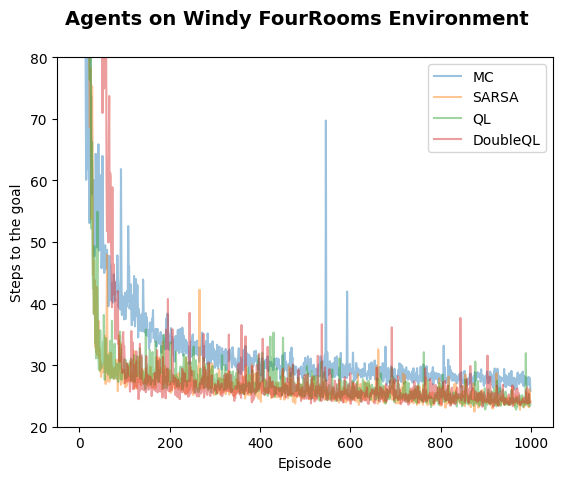

In [211]:
make_plot([perf_mc, perf_sarsa, perf_ql, perf_dql], 
          suptitle="Agents on Windy FourRooms Environment", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=['MC', 'SARSA', 'QL', "DoubleQL"], interval_yaxis=(20,80),
          alphas=[0.45]*4)

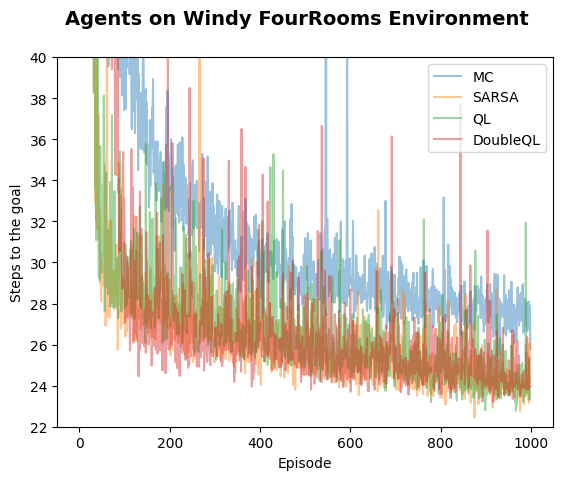

In [212]:
make_plot([perf_mc, perf_sarsa, perf_ql, perf_dql], 
          suptitle="Agents on Windy FourRooms Environment", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=['MC', 'SARSA', 'QL', "DoubleQL"], interval_yaxis=(22,40),
          alphas=[0.45]*4)

<span style="color:red"> **TODO** </span>: **Interpret** briefly your results; try to explain the main differences you observe.

We see that MC performs the worst overall.

## 5. <span style="color:green"> (2 point) </span>  <span style="color:blue"> **TODO** </span> Playground
Because QLearning learns the optimal value function and tends to learn an optimal policy faster than SARSA, it is most used in research. In this section, play around with the hyperparameters and design choices of QLearning. 

<span style="color:red"> **TODO** </span> For each hyperparameter or setting you play with, create a new subsection using `###` in markdown. Present your results in plots similar to the one above, comparing values and choices. Each curve should be averaged over $n_s=100$ seeds, to make for reliable graphs. Explain your experiments and analyze your results for each section. If you're testing an interesting value or new hyperparameter, try to also visualize what it changes using the `view_train_agent` function. 

### 5.1. Learning rate $\alpha$

We vary the learning rate using fixed values of $\epsilon=0.1$ and $\gamma=0.9$.

In [213]:
n_episodes = 1000
n_s = 100
d = {
    'env_shapes': env.shapes,
    'epsilon': 0.1,
    'alpha' : 0.2,
    'gamma': env.gamma,
}

In [214]:
alphas = [0.2, 0.4, 0.6, 0.8, 0.9]
perfs_ql = [] # contains all the performances
for alpha in alphas:
    d['alpha'] = alpha
    agent = QLearning(**d)
    perf_ql = multiple_train_agent(agent, env, n_episodes, n_s)
    perfs_ql.append(perf_ql)
    
# agent = QLearning(**d)
# perf_ql1 = multiple_train_agent(agent, env, n_episodes, n_s)
# d['alpha'] = 0.4
# agent = QLearning(**d)
# perf_ql2 = multiple_train_agent(agent, env, n_episodes, n_s)
# d['alpha'] = 0.8
# agent = QLearning(**d)
# perf_ql3 = multiple_train_agent(agent, env, n_episodes, n_s)

Done in 36.628870725631714s
Done in 34.786670446395874s
Done in 34.945311307907104s
Done in 34.551000118255615s
Done in 34.96307706832886s


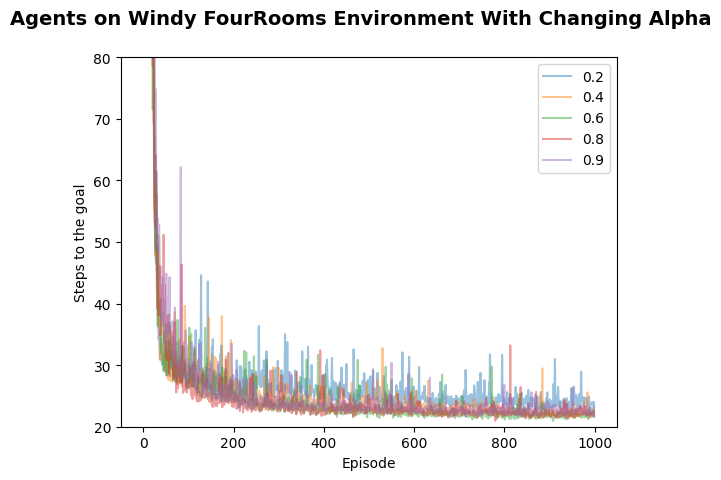

In [215]:
make_plot(perfs_ql,
          suptitle="Agents on Windy FourRooms Environment With Changing Alpha", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=[str(x) for x in alphas], interval_yaxis=(20,80),
          alphas=[0.45]*len(alphas))

### 5.2. Exploration rate $\epsilon$

We vary the exploration rate using fixed values of $\alpha=0.2$ and $\gamma=0.9$.

In [216]:
epsilons = [0.1, 0.2, 0.4, 0.6, 0.8]
perfs_ql = [] # contains all the performances
for epsilon in epsilons:
    d['epsilon'] = epsilon
    agent = QLearning(**d)
    perf_ql = multiple_train_agent(agent, env, n_episodes, n_s)
    perfs_ql.append(perf_ql)

Done in 35.168702602386475s
Done in 43.270572662353516s
Done in 70.22881388664246s
Done in 120.16614890098572s
Done in 382.50008273124695s


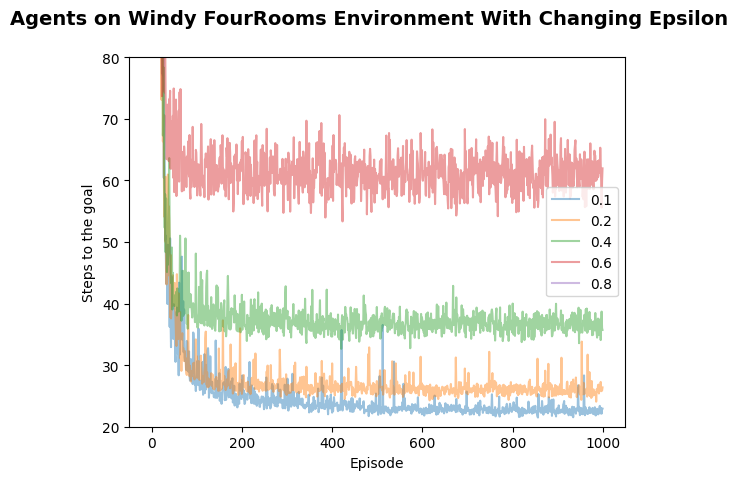

In [217]:
make_plot(perfs_ql,
          suptitle="Agents on Windy FourRooms Environment With Changing Epsilon", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=[str(x) for x in epsilons], interval_yaxis=(20,80),
          alphas=[0.45]*len(epsilons))

### 5.3. Discount factor $\gamma$

We vary the discount factor using fixed values of $\alpha=0.2$ and $\epsilon=0.1$.

In [218]:
gammas = [0.1, 0.3, 0.5, 0.7, 0.9] # fyi: env.gamma is 0.9 (I think)
perfs_ql = [] # contains all the performances
for gamma in gammas:
    d['gamma'] = gamma
    agent = QLearning(**d)
    perf_ql = multiple_train_agent(agent, env, n_episodes, n_s)
    perfs_ql.append(perf_ql)

Done in 353.5429530143738s


KeyboardInterrupt: 

In [ ]:
make_plot(perfs_ql,
          suptitle="Agents on Windy FourRooms Environment With Changing Gamma", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=[str(x) for x in gammas], interval_yaxis=(20,80),
          alphas=[0.45]*len(gammas))